# Simple Solution SymPy Code Generation

In [1]:
import pandas as pd
import numpy as np
import sympy as sym
sym.init_printing()
from thermoengine import coder
from thermoengine import core


## Simple Solution Properties - Structure of the Equations
There are three terms:
- Terms describing standard state contributions
- Terms describing the configurational entropy of solution
- Terms describing the excess enthalpy of solution  

Assumptions:
- There are $c$ components in the system
- There are as many endmember species, $s$, as there are components
- The configurational entropy is described as a simple $x_i log(x_i)$ sum
- The excess enthalpy is described using an asymmetric regular solution $\left[ {{W_{ij}} + \Delta {W_{ij}}\left( {{X_i} - {X_j}} \right)} \right]{X_i}{X_j}$, where the $W_{ij}$ and $\Delta{W_{ij}}$ are allowed to be first order functions of both $T$ and $P$
- Ternary interaction terms are permittted, i.e. $W_{ijk}$

## Number of solution components
This notebook illustrates a three component solution

In [2]:
c = 7

## Create a simple solution model
... with the specified number of endmember thermodynamic components

In [3]:
model = coder.SimpleSolnModel(nc=c)

## Retrieve primary compositional variables
- $n$ is a vector of mole numbers of each component  
- $n_T$ is the total number of moles in the solution
### and construct a derived mole fraction variable
- $X$ is a vector of mole fractions of components in the system

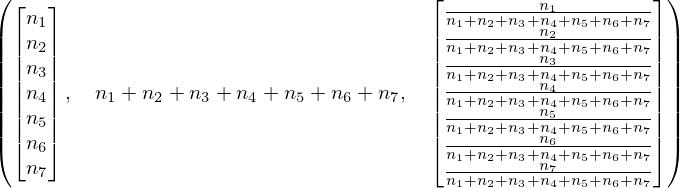

In [4]:
n = model.n
nT = model.nT
X = n/nT
n, nT, X

## Retrieve the temperature, pressure, and standard state chemical potentials
- $T$ is temperature in $K$
- $P$ is pressure in $bars$
- $\mu$ in Joules

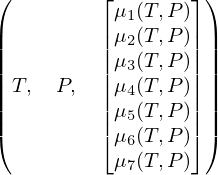

In [5]:
T = model.get_symbol_for_t()
P = model.get_symbol_for_p()
mu = model.mu
T,P,mu

## Define the standard state contribution to solution properties

In [6]:
G_ss = (n.transpose()*mu)[0]
G_ss

## Define configurational entropy and configurational Gibbs free energy

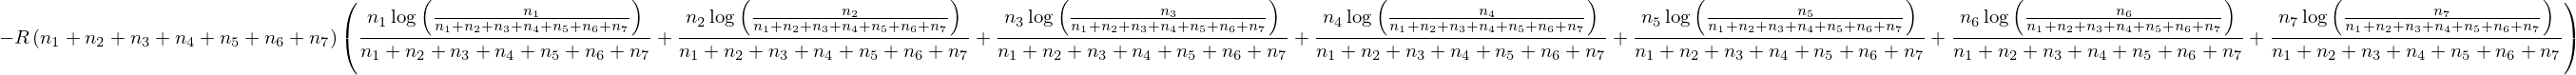

In [7]:
S_config,R = sym.symbols('S_config R')
S_config = 0
for i in range(0,c):
    S_config += X[i]*sym.log(X[i])
S_config *= -R*nT
S_config

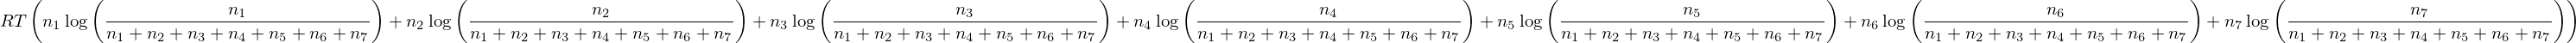

In [8]:
G_config = sym.simplify(-T*S_config)
G_config

## Parameterize the excess free energy
- Symmetric terms: $W_{ij} = Wh_{ij} - T Ws_{ij} + P Wv_{ij}$, where $Wh_{ij}$ is the excess enthalpy along the $i$-$j$ binary, $Ws_{ij}$ is the excess entropy, and $Wv_{ij}$ is the excess volume
- Asymetric terms: $\Delta W_{ij} = \Delta Wh_{ij} - T \Delta Ws_{ij} + P \Delta Wv_{ij}$
- Convention: $\left[ {{W_{ij}} + \Delta {W_{ij}}\left( {{X_i} - {X_j}} \right)} \right]{X_i}{X_j} = \left( {{W_{ij}} + \Delta {W_{ij}}} \right)X_i^2{X_j} + \left( {{W_{ij}} - \Delta {W_{ij}}} \right){X_i}X_j^2 = {W_{iij}}X_i^2{X_j} + {W_{ijj}}{X_i}X_j^2$  
- Strictly ternary terms: $W_{ijk}X_iX_jX_k$, where $i {\ne} j {\ne} k$

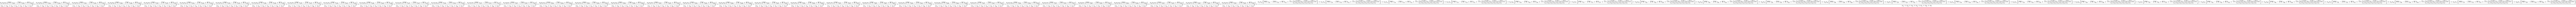

In [13]:
module = 'asymm_regular'
params = []
units = []
symparam = ()
G_excess = sym.symbols('G_excess')
G_excess = 0
for i in range(1,c):
    for j in range(i+1,c+1):
        param = 'Wh' + str(i) + str(j); params.append(param); units.append('J/m')
        h_term = sym.symbols(param); symparam += (h_term,)
        param = 'Ws' + str(i) + str(j); params.append(param); units.append('J/K-m')
        s_term = sym.symbols(param); symparam += (s_term,)
        param = 'Wv' + str(i) + str(j); params.append(param); units.append('J/bar-m')
        v_term = sym.symbols(param); symparam += (v_term,)
        param = 'dWh' + str(i) + str(j); params.append(param); units.append('J/m')
        dh_term = sym.symbols(param); symparam += (dh_term,)
        param = 'dWs' + str(i) + str(j); params.append(param); units.append('J/K-m')
        ds_term = sym.symbols(param); symparam += (ds_term,)
        param = 'dWv' + str(i) + str(j); params.append(param); units.append('J/bar-m')
        dv_term = sym.symbols(param); symparam += (dv_term,)
        w_term = h_term - T*s_term + P*v_term
        dw_term = dh_term - T*ds_term + P*dv_term
        G_excess += (w_term + dw_term*(n[i-1]-n[j-1])/nT)*n[i-1]*n[j-1]
G_excess /= nT
for i in range(1,c-1):
    for j in range(i+1,c):
        for k in range(j+1,c+1):
            param = 'Wh' + str(i) + str(j) + str(k); params.append(param); units.append('J/m')
            h_term = sym.symbols(param); symparam += (h_term,)
            param = 'Ws' + str(i) + str(j) + str(k); params.append(param); units.append('J/K-m')
            s_term = sym.symbols(param); symparam += (s_term,)
            param = 'Wv' + str(i) + str(j) + str(k); params.append(param); units.append('J/bar-m')
            v_term = sym.symbols(param); symparam += (v_term,)
            G_excess += (h_term - T*s_term + P*v_term)*n[i-1]*n[j-1]*n[k-1]/nT/nT
G_excess

In [10]:
print(params)
print(units)

['Wh12', 'Ws12', 'Wv12', 'dWh12', 'dWs12', 'dWv12', 'Wh13', 'Ws13', 'Wv13', 'dWh13', 'dWs13', 'dWv13', 'Wh14', 'Ws14', 'Wv14', 'dWh14', 'dWs14', 'dWv14', 'Wh15', 'Ws15', 'Wv15', 'dWh15', 'dWs15', 'dWv15', 'Wh16', 'Ws16', 'Wv16', 'dWh16', 'dWs16', 'dWv16', 'Wh17', 'Ws17', 'Wv17', 'dWh17', 'dWs17', 'dWv17', 'Wh23', 'Ws23', 'Wv23', 'dWh23', 'dWs23', 'dWv23', 'Wh24', 'Ws24', 'Wv24', 'dWh24', 'dWs24', 'dWv24', 'Wh25', 'Ws25', 'Wv25', 'dWh25', 'dWs25', 'dWv25', 'Wh26', 'Ws26', 'Wv26', 'dWh26', 'dWs26', 'dWv26', 'Wh27', 'Ws27', 'Wv27', 'dWh27', 'dWs27', 'dWv27', 'Wh34', 'Ws34', 'Wv34', 'dWh34', 'dWs34', 'dWv34', 'Wh35', 'Ws35', 'Wv35', 'dWh35', 'dWs35', 'dWv35', 'Wh36', 'Ws36', 'Wv36', 'dWh36', 'dWs36', 'dWv36', 'Wh37', 'Ws37', 'Wv37', 'dWh37', 'dWs37', 'dWv37', 'Wh45', 'Ws45', 'Wv45', 'dWh45', 'dWs45', 'dWv45', 'Wh46', 'Ws46', 'Wv46', 'dWh46', 'dWs46', 'dWv46', 'Wh47', 'Ws47', 'Wv47', 'dWh47', 'dWs47', 'dWv47', 'Wh56', 'Ws56', 'Wv56', 'dWh56', 'dWs56', 'dWv56', 'Wh57', 'Ws57', 'Wv57', 'dWh57

## Define the Gibbs free energy of solution

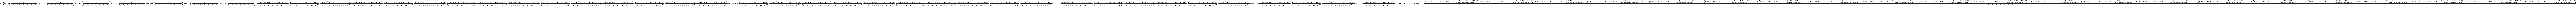

In [11]:
G = G_ss + G_config + G_excess
G


## Add the Gibbs free energy of solution to the model

In [25]:
model.add_expression_to_model(G, list(zip(params, units, symparam)))

... give the model a unqiue name

In [13]:
model.module = "Garnet_Solution"

In [14]:
model.formula_string = '(Mg[Mg]Fe[Fe]Mn[Mn]Ca[Ca])(Al[Al]Fe[Fe]Mg[Mg]Si[Si]Ti[Ti])Si3O12'
model.conversion_string = ['[0]=1/3[Mg]-1/2[Cr]-4/3[Si]', '[1]=1/3([Fe]-[Ti])', '[2]=1/3[Mn]', '[3]=1/3[Ca]-[Ti]', '[4]=1/2[Cr]', '[5]=[Ti]', '[6]=[Si]']
model.test_string = ['[0] > 0.0', '[1] > 0.0', '[2] > 0.0', '[3] > 0.0', '[4] > 0.0', '[5] > 0.0', '[6] > 0.0']

# Define Parameters of a Garnet Solution
Components
1. Pyrope, ${\rm{Mg_3Al_2Si_3O_{12}}}$
2. Almandine, ${\rm{Fe_3Al_2Si_3O_{12}}}$
3. Spessartine, ${\rm{Mn_3Al_2Si_3O_{12}}}$
4. Grossular, ${\rm{Ca_3Al_2Si_3O_{12}}}$
5. Knorringite, ${\rm{Mg_3Cr_2Si_3O_{12}}}$
6. Morimotoite, ${\rm{Ca_3TiFeSi_3O_{12}}}$
7. Majorite, ${\rm{Mg_3MgSiSi_3O_{12}}}$

Original calibration from the Elkins-Grove paper using their notation:
```
whabor   = 18810.0;  /* joules     */
wsabor   = 10.3;     /* joules/K   */
wvabor   = 0.4602;   /* joules/bar */
whorab   = 27320.0;  /* joules     */
wsorab   = 10.3;     /* joules/K   */
wvorab   = 0.3264;   /* joules/bar */
whaban   = 7924.0;   /* joules     */
whanab   = 0.0;      /* joules     */
whoran   = 40317.0;  /* joules     */
whanor   = 38974.0;  /* joules     */
wvanor   = -0.1037;  /* joules/bar */
whabanor = 12545.0;  /* joules     */
wvabanor = -1.095;   /* joules/bar */
```

Note that in the notation derveloped in this paper, $\left[ {{W_{ij}} + \Delta {W_{ij}}\left( {{X_i} - {X_j}} \right)} \right]{X_i}{X_j}$, is related to the convention used in the original paper: ${{\tilde W}_{13}}{X_1}{X_3}\left( {{X_3} + \frac{{{X_2}}}{2}} \right) + {{\tilde W}_{31}}{X_1}{X_3}\left( {{X_1} + \frac{{{X_2}}}{2}} \right)$:   
- ${W_{13}} = {{\tilde W}_{13}} + {{\tilde W}_{31}}$
- $d{W_{13}} = {{\tilde W}_{31}} - {{\tilde W}_{13}}$

In [15]:
print (params)
whabor   = 18810.0
wsabor   = 0.0
wvabor   = 0.0
whorab   = 27320.0
wsorab   = 0.0
wvorab   = 0.0
whaban   = 7924.0
whanab   = 0.0
whoran   = 40317.0
whanor   = 38974.0
wvanor   = 0
wvoran   = 0.0 
whabanor = 0.0
wvabanor = 0.0
paramValues = { 'Wh12':0,  'Ws12':0.0, 'Wv12':0.0, \
                'Wh13':0,  'Ws13':0,  'Wv13':0, \
                'Wh14':0,  'Ws14':0,  'Wv14':0, \
                'Wh15':0,  'Ws15':0,  'Wv15':0, \
                'Wh16':0,  'Ws16':0,  'Wv16':0, \
                'Wh17':0,  'Ws17':0,  'Wv17':0, \
                'Wh23':0,  'Ws23':0.0, 'Wv23':0, \
                'Wh24':0,  'Ws24':0.0, 'Wv24':0, \
                'Wh25':0,  'Ws25':0.0, 'Wv25':0, \
                'Wh26':0,  'Ws26':0.0, 'Wv26':0, \
                'Wh27':0,  'Ws27':0.0, 'Wv27':0, \
                'Wh34':0,  'Ws34':0.0, 'Wv34':0, \
                'Wh35':0,  'Ws35':0.0, 'Wv35':0, \
                'Wh36':0,  'Ws36':0.0, 'Wv36':0, \
                'Wh37':0,  'Ws37':0.0, 'Wv37':0, \
                'Wh45':0,  'Ws45':0.0, 'Wv45':0, \
                'Wh46':0,  'Ws46':0.0, 'Wv46':0, \
                'Wh47':0,  'Ws47':0.0, 'Wv47':0, \
                'Wh56':0,  'Ws56':0.0, 'Wv56':0, \
                'Wh57':0,  'Ws57':0.0, 'Wv57':0, \
                'Wh67':0,  'Ws67':0.0, 'Wv67':0, \
                'dWh12':0.0, 'dWs12':0.0, 'dWv12':0.0, \
                'dWh13':0.0, 'dWs13':0, 'dWv13':0, \
                'dWh14':0,  'dWs14':0,  'dWv14':0, \
                'dWh15':0,  'dWs15':0,  'dWv15':0, \
                'dWh16':0,  'dWs16':0,  'dWv16':0, \
                'dWh17':0,  'dWs17':0,  'dWv17':0, \
                'dWh23':0.0, 'dWs23':0.0, 'dWv23':0,\
                'dWh24':0,  'dWs24':0.0, 'dWv24':0, \
                'dWh25':0,  'dWs25':0.0, 'dWv25':0, \
                'dWh26':0,  'dWs26':0.0, 'dWv26':0, \
                'dWh27':0,  'dWs27':0.0, 'dWv27':0, \
                'dWh34':0,  'dWs34':0.0, 'dWv34':0, \
                'dWh35':0,  'dWs35':0.0, 'dWv35':0, \
                'dWh36':0,  'dWs36':0.0, 'dWv36':0, \
                'dWh37':0,  'dWs37':0.0, 'dWv37':0, \
                'dWh45':0,  'dWs45':0.0, 'dWv45':0, \
                'dWh46':0,  'dWs46':0.0, 'dWv46':0, \
                'dWh47':0,  'dWs47':0.0, 'dWv47':0, \
                'dWh56':0,  'dWs56':0.0, 'dWv56':0, \
                'dWh57':0,  'dWs57':0.0, 'dWv57':0, \
                'dWh67':0,  'dWs67':0.0, 'dWv67':0, \
                'Wh123':0, 'Ws123':0.0, 'Wv123':0, \
                'Wh124':0, 'Ws124':0.0, 'Wv124':0, \
                'Wh125':0, 'Ws125':0.0, 'Wv125':0, \
                'Wh126':0, 'Ws126':0.0, 'Wv126':0, \
                'Wh127':0, 'Ws127':0.0, 'Wv127':0, \
                'Wh134':0, 'Ws134':0.0, 'Wv134':0, \
                'Wh135':0, 'Ws135':0.0, 'Wv135':0, \
                'Wh136':0, 'Ws136':0.0, 'Wv136':0, \
                'Wh137':0, 'Ws137':0.0, 'Wv137':0, \
                'Wh145':0, 'Ws145':0.0, 'Wv145':0, \
                'Wh146':0, 'Ws146':0.0, 'Wv146':0, \
                'Wh147':0, 'Ws147':0.0, 'Wv147':0, \
                'Wh156':0, 'Ws156':0.0, 'Wv156':0, \
                'Wh157':0, 'Ws157':0.0, 'Wv157':0, \
                'Wh167':0, 'Ws167':0.0, 'Wv167':0, \
                'Wh234':0, 'Ws234':0.0, 'Wv234':0, \
                'Wh235':0, 'Ws235':0.0, 'Wv235':0, \
                'Wh236':0, 'Ws236':0.0, 'Wv236':0, \
                'Wh237':0, 'Ws237':0.0, 'Wv237':0, \
                'Wh245':0, 'Ws245':0.0, 'Wv245':0, \
                'Wh246':0, 'Ws246':0.0, 'Wv246':0, \
                'Wh247':0, 'Ws247':0.0, 'Wv247':0, \
                'Wh256':0, 'Ws256':0.0, 'Wv256':0, \
                'Wh257':0, 'Ws257':0.0, 'Wv257':0, \
                'Wh267':0, 'Ws267':0.0, 'Wv267':0, \
                'Wh345':0, 'Ws345':0.0, 'Wv345':0, \
                'Wh346':0, 'Ws346':0.0, 'Wv346':0, \
                'Wh347':0, 'Ws347':0.0, 'Wv347':0, \
                'Wh356':0, 'Ws356':0.0, 'Wv356':0, \
                'Wh357':0, 'Ws357':0.0, 'Wv357':0, \
                'Wh367':0, 'Ws367':0.0, 'Wv367':0, \
                'Wh456':0, 'Ws456':0.0, 'Wv456':0, \
                'Wh457':0, 'Ws457':0.0, 'Wv457':0, \
                'Wh467':0, 'Ws467':0.0, 'Wv467':0, \
                'Wh567':0, 'Ws567':0.0, 'Wv567':0, \
                'T_r':298.15, 'P_r':1.0}
print (paramValues)

['Wh12', 'Ws12', 'Wv12', 'dWh12', 'dWs12', 'dWv12', 'Wh13', 'Ws13', 'Wv13', 'dWh13', 'dWs13', 'dWv13', 'Wh14', 'Ws14', 'Wv14', 'dWh14', 'dWs14', 'dWv14', 'Wh15', 'Ws15', 'Wv15', 'dWh15', 'dWs15', 'dWv15', 'Wh16', 'Ws16', 'Wv16', 'dWh16', 'dWs16', 'dWv16', 'Wh17', 'Ws17', 'Wv17', 'dWh17', 'dWs17', 'dWv17', 'Wh23', 'Ws23', 'Wv23', 'dWh23', 'dWs23', 'dWv23', 'Wh24', 'Ws24', 'Wv24', 'dWh24', 'dWs24', 'dWv24', 'Wh25', 'Ws25', 'Wv25', 'dWh25', 'dWs25', 'dWv25', 'Wh26', 'Ws26', 'Wv26', 'dWh26', 'dWs26', 'dWv26', 'Wh27', 'Ws27', 'Wv27', 'dWh27', 'dWs27', 'dWv27', 'Wh34', 'Ws34', 'Wv34', 'dWh34', 'dWs34', 'dWv34', 'Wh35', 'Ws35', 'Wv35', 'dWh35', 'dWs35', 'dWv35', 'Wh36', 'Ws36', 'Wv36', 'dWh36', 'dWs36', 'dWv36', 'Wh37', 'Ws37', 'Wv37', 'dWh37', 'dWs37', 'dWv37', 'Wh45', 'Ws45', 'Wv45', 'dWh45', 'dWs45', 'dWv45', 'Wh46', 'Ws46', 'Wv46', 'dWh46', 'dWs46', 'dWv46', 'Wh47', 'Ws47', 'Wv47', 'dWh47', 'dWs47', 'dWv47', 'Wh56', 'Ws56', 'Wv56', 'dWh56', 'dWs56', 'dWv56', 'Wh57', 'Ws57', 'Wv57', 'dWh57

Generate both fast computation and calibibration code for the feldspar solution

# Use code printers to construct "C" package code

In [16]:
model_working_dir = "working"
!mkdir -p {model_working_dir}
%cd {model_working_dir}

/Users/jennaadams/Documents/projects/ThermoEngine/Notebooks/Codegen/working


## Choose model type and create model
model_type is "fast" or "calib"

In [17]:
model_type = "calib"

In [18]:
model.create_code_module(phase="Garnet", params=paramValues, 
                         endmembers=['Pyrope_Garnet', 'Almandine_Garnet', 'Spessartine_Garnet', 'Grossular_Garnet', 'Knorringite_Garnet', 'Morimotoite_Garnet', 'Majorite_Garnet'], 
                         prefix="cy", module_type=model_type, silent=False)

Creating generic fast model code file string
Writing include file to working directory ...
Creating (once only) generic model calib codetemplate include file string
Creating (once only) generic model calib codetemplate code file string
Creating generic calib model code file string
Writing include file to working directory ...
Creating code blocks for standard state properties.
Creating calib code and include files ...
Writing include file to working directory ...
Writing code file to working directory ...
... done
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  Garnet_Solution


True

## Load the module

In [19]:

import Garnet_Solution
%cd ..

/Users/jennaadams/Documents/projects/ThermoEngine/Notebooks/Codegen


## Test and time the generated functions for Garnet (T in K, P in bars)

In [20]:
t = 2000.00
p = 1.0
n = np.array([1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7])

## Available in both "Fast" and "Calib" code versions 
Execute the "fast" or "calibration" code metadata retrieval functions:

In [21]:
try:
    print(Garnet_Solution.cy_Garnet_Garnet_Solution_identifier())
    print(Garnet_Solution.cy_Garnet_Garnet_Solution_name())
except AttributeError:
    pass
try:
    print(Garnet_Solution.cy_Garnet_Garnet_Solution_calib_identifier())
    print(Garnet_Solution.cy_Garnet_Garnet_Solution_calib_name())
except AttributeError:
    pass

Fri Feb  1 10:08:51 2019
Garnet


Test intrinsic element conversion routine ...

In [22]:
try:
    e = np.zeros(106)
    sum = np.sum(n)
    for index in range(0,c):
        end = Garnet_Solution.cy_Garnet_Garnet_Solution_endmember_elements(index)
        for i in range(0,106):
            e[i] += end[i]*n[index]/sum
    nConv = Garnet_Solution.cy_Garnet_Garnet_Solution_conv_elm_to_moles(e)
    for i in range(0,c):
        print ('X[{0:d}] input {1:13.6e}, calc {2:13.6e}, diff {3:13.6e}'.format(
        i, n[i]/sum, nConv[i], nConv[i]-n[i]/sum))
    if not Garnet_Solution.cy_Garnet_Garnet_Solution_test_moles(nConv):
        print ('Output of intrinsic composition calculation fails tests for permissible values.')
except AttributeError:
    pass
try:
    e = np.zeros(106)
    sum = np.sum(n)
    for index in range(0,c):
        end = Garnet_Solution.cy_Garnet_Garnet_Solution_calib_endmember_elements(index)
        for i in range(0,106):
            e[i] += end[i]*n[index]/sum
    nConv = Garnet_Solution.cy_Garnet_Garnet_Solution_calib_conv_elm_to_moles(e)
    for i in range(0,c):
        print ('X[{0:d}] input {1:13.6e}, calc {2:13.6e}, diff {3:13.6e}'.format(
        i, n[i]/sum, nConv[i], nConv[i]-n[i]/sum))
    if not Garnet_Solution.cy_Garnet_Garnet_Solution_calib_test_moles(nConv):
        print ('Output of intrinsic composition calculation fails tests for permissible values.')
except AttributeError:
    pass

X[0] input  1.122449e-01, calc  1.153061e+00, diff  1.040816e+00
X[1] input  1.224490e-01, calc  3.673469e-01, diff  2.448980e-01
X[2] input  1.326531e-01, calc  3.979592e-01, diff  2.653061e-01
X[3] input  1.428571e-01, calc  2.653061e-01, diff  1.224490e-01
X[4] input  1.530612e-01, calc  3.061224e-01, diff  1.530612e-01
X[5] input  1.632653e-01, calc  1.632653e-01, diff  0.000000e+00
X[6] input  1.734694e-01, calc  1.459184e+00, diff  1.285714e+00


In [23]:
try:
    print (Garnet_Solution.cy_Garnet_Garnet_Solution_calib_conv_moles_to_tot_moles(n))
    print (Garnet_Solution.cy_Garnet_Garnet_Solution_calib_conv_moles_to_mole_frac(n))
    e = Garnet_Solution.cy_Garnet_Garnet_Solution_calib_conv_moles_to_elm(n)
    print (e)
    print (Garnet_Solution.cy_Garnet_Garnet_Solution_calib_conv_elm_to_moles(e))
    print (Garnet_Solution.cy_Garnet_Garnet_Solution_calib_conv_elm_to_tot_moles(e))
    print (Garnet_Solution.cy_Garnet_Garnet_Solution_calib_conv_elm_to_tot_grams(e))
except AttributeError:
    pass
try:
    print (Garnet_Solution.cy_Garnet_Garnet_Solution_conv_moles_to_tot_moles(n))
    print (Garnet_Solution.cy_Garnet_Garnet_Solution_conv_moles_to_mole_frac(n))
    e = Garnet_Solution.cy_Garnet_Garnet_Solution_conv_moles_to_elm(n)
    print (e)
    print (Garnet_Solution.cy_Garnet_Garnet_Solution_conv_elm_to_moles(e))
    print (Garnet_Solution.cy_Garnet_Garnet_Solution_conv_elm_to_tot_moles(e))
    print (Garnet_Solution.cy_Garnet_Garnet_Solution_conv_elm_to_tot_grams(e))
except AttributeError:
    pass

9.799999999999999
[0.1122449  0.12244898 0.13265306 0.14285714 0.15306122 0.16326531
 0.17346939]
[  0.    0.    0.    0.    0.    0.    0.    0.  117.6   0.    0.    0.
  14.3  10.   29.4   0.    0.    0.    0.    0.    4.2   0.    1.6   0.
   3.    3.9   5.2   0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
[11.3  3.6  3.9  2.6  3.   1.6 14.3]
40.3
17275.391252


### Execute the standard thermodynamic property retrieval functions:

In [24]:
fmt = "{0:<10.10s} {1:13.6e} {2:<10.10s}"
try:
    print(fmt.format('G', Garnet_Solution.cy_Garnet_Garnet_Solution_g(t,p,n), 'J'))
    print(fmt.format('dGdT', Garnet_Solution.cy_Garnet_Garnet_Solution_dgdt(t,p,n), 'J/K'))
    print(fmt.format('dGdP', Garnet_Solution.cy_Garnet_Garnet_Solution_dgdp(t,p,n), 'J/bar'))
    print(fmt.format('d2GdT2', Garnet_Solution.cy_Garnet_Garnet_Solution_d2gdt2(t,p,n), 'J/K^2'))
    print(fmt.format('d2GdTdP', Garnet_Solution.cy_Garnet_Garnet_Solution_d2gdtdp(t,p,n), 'J/K-bar'))
    print(fmt.format('d2GdP2', Garnet_Solution.cy_Garnet_Garnet_Solution_d2gdp2(t,p,n), 'J/bar^2'))
    print(fmt.format('d3GdT3', Garnet_Solution.cy_Garnet_Garnet_Solution_d3gdt3(t,p,n), 'J/K^3'))
    print(fmt.format('d3GdT2dP', Garnet_Solution.cy_Garnet_Garnet_Solution_d3gdt2dp(t,p,n), 'J/K^2-bar'))
    print(fmt.format('d3GdTdP2', Garnet_Solution.cy_Garnet_Garnet_Solution_d3gdtdp2(t,p,n), 'J/K-bar^2'))
    print(fmt.format('d3GdP3', Garnet_Solution.cy_Garnet_Garnet_Solution_d3gdp3(t,p,n), 'J/bar^3'))
    print(fmt.format('S', Garnet_Solution.cy_Garnet_Garnet_Solution_s(t,p,n), 'J/K'))
    print(fmt.format('V', Garnet_Solution.cy_Garnet_Garnet_Solution_v(t,p,n), 'J/bar'))
    print(fmt.format('Cv', Garnet_Solution.cy_Garnet_Garnet_Solution_cv(t,p,n), 'J/K'))
    print(fmt.format('Cp', Garnet_Solution.cy_Garnet_Garnet_Solution_cp(t,p,n), 'J/K'))
    print(fmt.format('dCpdT', Garnet_Solution.cy_Garnet_Garnet_Solution_dcpdt(t,p,n), 'J/K^2'))
    print(fmt.format('alpha', Garnet_Solution.cy_Garnet_Garnet_Solution_alpha(t,p,n), '1/K'))
    print(fmt.format('beta', Garnet_Solution.cy_Garnet_Garnet_Solution_beta(t,p,n), '1/bar'))
    print(fmt.format('K', Garnet_Solution.cy_Garnet_Garnet_Solution_K(t,p,n), 'bar'))
    print(fmt.format('Kp', Garnet_Solution.cy_Garnet_Garnet_Solution_Kp(t,p,n), ''))
except AttributeError:
    pass
try:
    print(fmt.format('G', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_g(t,p,n), 'J'))
    print(fmt.format('dGdT', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_dgdt(t,p,n), 'J/K'))
    print(fmt.format('dGdP', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_dgdp(t,p,n), 'J/bar'))
    print(fmt.format('d2GdT2', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d2gdt2(t,p,n), 'J/K^2'))
    print(fmt.format('d2GdTdP', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d2gdtdp(t,p,n), 'J/K-bar'))
    print(fmt.format('d2GdP2', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d2gdp2(t,p,n), 'J/bar^2'))
    print(fmt.format('d3GdT3', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d3gdt3(t,p,n), 'J/K^3'))
    print(fmt.format('d3GdT2dP', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d3gdt2dp(t,p,n), 'J/K^2-bar'))
    print(fmt.format('d3GdTdP2', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d3gdtdp2(t,p,n), 'J/K-bar^2'))
    print(fmt.format('d3GdP3', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d3gdp3(t,p,n), 'J/bar^3'))
    print(fmt.format('S', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_s(t,p,n), 'J/K'))
    print(fmt.format('V', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_v(t,p,n), 'J/bar'))
    print(fmt.format('Cv', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_cv(t,p,n), 'J/K'))
    print(fmt.format('Cp', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_cp(t,p,n), 'J/K'))
    print(fmt.format('dCpdT', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_dcpdt(t,p,n), 'J/K^2'))
    print(fmt.format('alpha', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_alpha(t,p,n), '1/K'))
    print(fmt.format('beta', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_beta(t,p,n), '1/bar'))
    print(fmt.format('K', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_K(t,p,n), 'bar'))
    print(fmt.format('Kp', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_Kp(t,p,n), ''))
except AttributeError:
    pass

G          -7.554232e+07 J         
dGdT       -1.139617e+04 J/K       
dGdP        1.185488e+02 J/bar     
d2GdT2     -2.623570e+00 J/K^2     
d2GdTdP     4.281883e-03 J/K-bar   
d2GdP2     -6.612905e-05 J/bar^2   
d3GdT3      1.196361e-03 J/K^3     
d3GdT2dP    1.090966e-06 J/K^2-bar 
d3GdTdP2    0.000000e+00 J/K-bar^2 
d3GdP3      0.000000e+00 J/bar^3   
S           1.139617e+04 J/K       
V           1.185488e+02 J/bar     
Cv          4.692632e+03 J/K       
Cp          5.247139e+03 J/K       
dCpdT       2.308475e-01 J/K^2     
alpha       3.611914e-05 1/K       
beta        5.578211e-07 1/bar     
K           1.792689e+06 bar       
Kp         -1.000000e+00           


### Execute functions that access endmember properties:

In [27]:
fmt = "{0:<10.10s} {1:13.6e} {2:<15.15s}"
try:
    print ("number of components", Garnet_Solution.cy_Garnet_Garnet_Solution_endmember_number())
    for index in range(0, c):
        print ("{0:<20.20s}".format(Garnet_Solution.cy_Garnet_Garnet_Solution_endmember_name(index)), end=' ')
        print ("{0:<20.20s}".format(Garnet_Solution.cy_Garnet_Garnet_Solution_endmember_formula(index)))
        print ("mw: {0:10.2f}".format(Garnet_Solution.cy_Garnet_Garnet_Solution_endmember_mw(index)))
        print (fmt.format('mu0', Garnet_Solution.cy_Garnet_Garnet_Solution_endmember_mu0(index,t,p), 'J/mol'))
        print (fmt.format('dmu0dT', Garnet_Solution.cy_Garnet_Garnet_Solution_endmember_dmu0dT(index,t,p), 'J/K-mol'))
        print (fmt.format('dmu0dP', Garnet_Solution.cy_Garnet_Garnet_Solution_endmember_dmu0dP(index,t,p), 'J/bar-mol'))
        print (fmt.format('d2mu0dT2', Garnet_Solution.cy_Garnet_Garnet_Solution_endmember_d2mu0dT2(index,t,p), 'J/K^2-mol'))
        print (fmt.format('d2mu0dTdP', Garnet_Solution.cy_Garnet_Garnet_Solution_endmember_d2mu0dTdP(index,t,p), 'J/K-bar-mol'))
        print (fmt.format('d2mu0dP2', Garnet_Solution.cy_Garnet_Garnet_Solution_endmember_d2mu0dP2(index,t,p), 'J/bar^2-mol'))
        print (fmt.format('d3mu0dT3', Garnet_Solution.cy_Garnet_Garnet_Solution_endmember_d3mu0dT3(index,t,p), 'J/K^3-mol'))
        print (fmt.format('d3mu0dT2dP', Garnet_Solution.cy_Garnet_Garnet_Solution_endmember_d3mu0dT2dP(index,t,p), 'J/K^2-bar-mol'))
        print (fmt.format('d3mu0dTdP2', Garnet_Solution.cy_Garnet_Garnet_Solution_endmember_d3mu0dTdP2(index,t,p), 'J/K-bar^2-mol'))
        print (fmt.format('d3mu0dP3', Garnet_Solution.cy_Garnet_Garnet_Solution_endmember_d3mu0dP3(index,t,p), 'J/bar^3-mol'))
        print ("Element array:")
        print (Garnet_Solution.cy_Garnet_Garnet_Solution_endmember_elements(index))
        print ()
except AttributeError:
    pass
try:
    print ("number of components", Garnet_Solution.cy_Garnet_Garnet_Solution_calib_endmember_number())
    for index in range(0, c):
        print ("{0:<20.20s}".format(Garnet_Solution.cy_Garnet_Garnet_Solution_calib_endmember_name(index)), end=' ')
        print ("{0:<20.20s}".format(Garnet_Solution.cy_Garnet_Garnet_Solution_calib_endmember_formula(index)), end=' ')
        print ("mw: {0:10.2f}".format(Garnet_Solution.cy_Garnet_Garnet_Solution_calib_endmember_mw(index)))
        print (fmt.format('mu0', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_endmember_mu0(index,t,p), 'J/mol'))
        print (fmt.format('dmu0dT', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_endmember_dmu0dT(index,t,p), 'J/K-mol'))
        print (fmt.format('dmu0dP', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_endmember_dmu0dP(index,t,p), 'J/bar-mol'))
        print (fmt.format('d2mu0dT2', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_endmember_d2mu0dT2(index,t,p), 'J/K^2-mol'))
        print (fmt.format('d2mu0dTdP', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_endmember_d2mu0dTdP(index,t,p), 'J/K-bar-mol'))
        print (fmt.format('d2mu0dP2', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_endmember_d2mu0dP2(index,t,p), 'J/bar^2-mol'))
        print (fmt.format('d3mu0dT3', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_endmember_d3mu0dT3(index,t,p), 'J/K^3-mol'))
        print (fmt.format('d3mu0dT2dP', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_endmember_d3mu0dT2dP(index,t,p), 'J/K^2-bar-mol'))
        print (fmt.format('d3mu0dTdP2', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_endmember_d3mu0dTdP2(index,t,p), 'J/K-bar^2-mol'))
        print (fmt.format('d3mu0dP3', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_endmember_d3mu0dP3(index,t,p), 'J/bar^3-mol'))
        print ("Element array:")
        print (Garnet_Solution.cy_Garnet_Garnet_Solution_calib_endmember_elements(index))
        print ()
except AttributeError:
    pass

number of components 7
Pyrope               Mg3Al2Si3O12         mw:     403.13
mu0        -7.732988e+06 J/mol          
dmu0dT     -1.137016e+03 J/K-mol        
dmu0dP      1.187093e+01 J/bar-mol      
d2mu0dT2   -2.689904e-01 J/K^2-mol      
d2mu0dTdP   3.973318e-04 J/K-bar-mol    
d2mu0dP2   -6.520279e-06 J/bar^2-mol    
d3mu0dT3    1.212120e-04 J/K^3-mol      
d3mu0dT2dP  8.373840e-08 J/K^2-bar-mol  
d3mu0dTdP2  0.000000e+00 J/K-bar^2-mol  
d3mu0dP3    0.000000e+00 J/bar^3-mol    
Element array:
[ 0.  0.  0.  0.  0.  0.  0.  0. 12.  0.  0.  0.  3.  2.  3.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

Almandine            Si3Fe3Al2O12         mw:     497.75
mu0   

### Execute functions that access species properties:

In [28]:
fmt = "{0:<10.10s} {1:13.6e} {2:<15.15s}"
try:
    print ("number of species", Garnet_Solution.cy_Garnet_Garnet_Solution_species_number())
    for index in range(0, c):
        print ("{0:<20.20s}".format(Garnet_Solution.cy_Garnet_Garnet_Solution_species_name(index)), end=' ')
        print ("{0:<20.20s}".format(Garnet_Solution.cy_Garnet_Garnet_Solution_species_formula(index)))
        print ("mw: {0:10.2f}".format(Garnet_Solution.cy_Garnet_Garnet_Solution_species_mw(index)))
        print ("Element array:")
        print (Garnet_Solution.cy_Garnet_Garnet_Solution_species_elements(index))
        print ()
except AttributeError:
    pass
try:
    print ("number of species", Garnet_Solution.cy_Garnet_Garnet_Solution_calib_species_number())
    for index in range(0, c):
        print ("{0:<20.20s}".format(Garnet_Solution.cy_Garnet_Garnet_Solution_calib_species_name(index)), end=' ')
        print ("{0:<20.20s}".format(Garnet_Solution.cy_Garnet_Garnet_Solution_calib_species_formula(index)), end=' ')
        print ("mw: {0:10.2f}".format(Garnet_Solution.cy_Garnet_Garnet_Solution_calib_species_mw(index)))
        print ("Element array:")
        print (Garnet_Solution.cy_Garnet_Garnet_Solution_calib_species_elements(index))
        print ()
except AttributeError:
    pass

number of species 7
Pyrope               Mg3Al2Si3O12         mw:     403.13
Element array:
[ 0.  0.  0.  0.  0.  0.  0.  0. 12.  0.  0.  0.  3.  2.  3.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

Almandine            Si3Fe3Al2O12         mw:     497.75
Element array:
[ 0.  0.  0.  0.  0.  0.  0.  0. 12.  0.  0.  0.  0.  2.  3.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

### Execute functions for molar derivatives
#### First derivative vectors:

In [29]:
def printResult(name, result, units):
    print ("{0:<10.10s}".format(name), end=' ')
    [print ("{0:13.6e}".format(x), end=' ') for x in result]
    print ("{0:<10.10s}".format(units))
def printLabels(n):
    print ("{0:<18.18s}".format(''), end=' ')
    [print ("[{0:3d}]{1:<8.8s}".format(idx, ''), end=' ') for idx in range(len(n))]
    print ()
printLabels(n)
try:
    printResult('dGdn', Garnet_Solution.cy_Garnet_Garnet_Solution_dgdn(t,p,n), 'J/m')
    printResult('d2GdndT', Garnet_Solution.cy_Garnet_Garnet_Solution_d2gdndt(t,p,n), 'J/K-m')
    printResult('d2GdndP', Garnet_Solution.cy_Garnet_Garnet_Solution_d2gdndp(t,p,n), 'J/bar-m')
    printResult('d3GdndT2', Garnet_Solution.cy_Garnet_Garnet_Solution_d3gdndt2(t,p,n), 'J/K^2-m')
    printResult('d3GdndTdP', Garnet_Solution.cy_Garnet_Garnet_Solution_d3gdndtdp(t,p,n), 'J/K-bar-m')
    printResult('d3GdndP2', Garnet_Solution.cy_Garnet_Garnet_Solution_d3gdndp2(t,p,n), 'J/bar^2-m')
    printResult('d4GdndT3', Garnet_Solution.cy_Garnet_Garnet_Solution_d4gdndt3(t,p,n), 'J/K^3-m')
    printResult('d4GdndT2dP', Garnet_Solution.cy_Garnet_Garnet_Solution_d4gdndt2dp(t,p,n), 'J/K^2-bar-m')
    printResult('d4GdndTdP2', Garnet_Solution.cy_Garnet_Garnet_Solution_d4gdndtdp2(t,p,n), 'J/K-bar^2-m')
    printResult('d4GdndP3', Garnet_Solution.cy_Garnet_Garnet_Solution_d4gdndp3(t,p,n), 'J/bar^3-m')
except AttributeError:
    pass
try:
    printResult('dGdn', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_dgdn(t,p,n), 'J/m')
    printResult('d2GdndT', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d2gdndt(t,p,n), 'J/K-m')
    printResult('d2GdndP', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d2gdndp(t,p,n), 'J/bar-m')
    printResult('d3GdndT2', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d3gdndt2(t,p,n), 'J/K^2-m')
    printResult('d3GdndTdP', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d3gdndtdp(t,p,n), 'J/K-bar-m')
    printResult('d3GdndP2', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d3gdndp2(t,p,n), 'J/bar^2-m')
    printResult('d4GdndT3', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d4gdndt3(t,p,n), 'J/K^3-m')
    printResult('d4GdndT2dP', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d4gdndt2dp(t,p,n), 'J/K^2-bar-m')
    printResult('d4GdndTdP2', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d4gdndtdp2(t,p,n), 'J/K-bar^2-m')
    printResult('d4GdndP3', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d4gdndp3(t,p,n), 'J/bar^3-m')
except AttributeError:
    pass    

                   [  0]         [  1]         [  2]         [  3]         [  4]         [  5]         [  6]         
dGdn       -7.769356e+06 -6.918538e+06 -7.766578e+06 -8.095950e+06 -7.764199e+06 -7.763125e+06 -7.762117e+06 J/m       
d2GdndT    -1.155200e+03 -1.246208e+03 -1.153811e+03 -1.142927e+03 -1.152621e+03 -1.152084e+03 -1.151580e+03 J/K-m     
d2GdndP     1.187093e+01  1.212566e+01  1.187093e+01  1.323380e+01  1.187093e+01  1.187093e+01  1.187093e+01 J/bar-m   
d3GdndT2   -2.689904e-01 -2.670515e-01 -2.689904e-01 -2.616980e-01 -2.689904e-01 -2.689904e-01 -2.689904e-01 J/K^2-m   
d3GdndTdP   3.973318e-04  5.080984e-04  3.973318e-04  5.795540e-04  3.973318e-04  3.973318e-04  3.973318e-04 J/K-bar-m 
d3GdndP2   -6.520279e-06 -6.420836e-06 -6.520279e-06 -8.198598e-06 -6.520279e-06 -6.520279e-06 -6.520279e-06 J/bar^2-m 
d4GdndT3    1.212120e-04  1.261896e-04  1.212120e-04  1.230052e-04  1.212120e-04  1.212120e-04  1.212120e-04 J/K^3-m   
d4GdndT2dP  8.373840e-08  1.726650e-07  8.

#### The Hessian matrix (molar second derivative matrix) is stored as a compact linear array
A function is provided to map matrix indices to compact storage 1-D array indices

In [30]:
for i in range(1,c+1):
    print ("[ ", end=' ')
    for j in range (1,c+1):
        print ((i,j), end=' ')
    print (']     [', end=' ')
    for j in range (1,c+1):
        print (model.symmetric_index_from_2d_array(elm=(i,j)), end=' ')
    print (']')

[  (1, 1) (1, 2) (1, 3) (1, 4) (1, 5) (1, 6) (1, 7) ]     [ 0 1 2 3 4 5 6 ]
[  (2, 1) (2, 2) (2, 3) (2, 4) (2, 5) (2, 6) (2, 7) ]     [ 1 7 8 9 10 11 12 ]
[  (3, 1) (3, 2) (3, 3) (3, 4) (3, 5) (3, 6) (3, 7) ]     [ 2 8 13 14 15 16 17 ]
[  (4, 1) (4, 2) (4, 3) (4, 4) (4, 5) (4, 6) (4, 7) ]     [ 3 9 14 18 19 20 21 ]
[  (5, 1) (5, 2) (5, 3) (5, 4) (5, 5) (5, 6) (5, 7) ]     [ 4 10 15 19 22 23 24 ]
[  (6, 1) (6, 2) (6, 3) (6, 4) (6, 5) (6, 6) (6, 7) ]     [ 5 11 16 20 23 25 26 ]
[  (7, 1) (7, 2) (7, 3) (7, 4) (7, 5) (7, 6) (7, 7) ]     [ 6 12 17 21 24 26 27 ]


In [31]:
def printResult(name, result, units):
    print ("{0:<10.10s}".format(name), end=' ')
    [print ("{0:13.6e}".format(x), end=' ') for x in result]
    print ("{0:<10.10s}".format(units))
def printLabels(n):
    print ("{0:<18.18s}".format(''), end=' ')
    maxIdx = int(len(n)*(len(n)-1)/2 + len(n))
    [print ("[{0:3d}]{1:<8.8s}".format(idx, ''), end=' ') for idx in range(maxIdx)]
    print ()
printLabels(n)
try:
    printResult('d2Gdn2', Garnet_Solution.cy_Garnet_Garnet_Solution_d2gdn2(t,p,n), 'J/m^2')
    printResult('d3Gdn2dT', Garnet_Solution.cy_Garnet_Garnet_Solution_d3gdn2dt(t,p,n), 'J/K-m^2')
    printResult('d3Gdn2dP', Garnet_Solution.cy_Garnet_Garnet_Solution_d3gdn2dp(t,p,n), 'J/bar-m^2')
    printResult('d4Gdn2dT2', Garnet_Solution.cy_Garnet_Garnet_Solution_d4gdn2dt2(t,p,n), 'J/K^2-m^2')
    printResult('d4Gdn2dTdP', Garnet_Solution.cy_Garnet_Garnet_Solution_d4gdn2dtdp(t,p,n), 'J/K-bar-m^2')
    printResult('d4Gdn2dP2', Garnet_Solution.cy_Garnet_Garnet_Solution_d4gdn2dp2(t,p,n), 'J/bar^2-m^2')
    printResult('d5Gdn2dT3', Garnet_Solution.cy_Garnet_Garnet_Solution_d5gdn2dt3(t,p,n), 'J/K^3-m^2')
    printResult('d5Gdn2dT2dP', Garnet_Solution.cy_Garnet_Garnet_Solution_d5gdn2dt2dp(t,p,n), 'J/K^2-bar-m^2')
    printResult('d5Gdn2dTdP2', Garnet_Solution.cy_Garnet_Garnet_Solution_d5gdn2dtdp2(t,p,n), 'J/K-bar^2-m^2')
    printResult('d5Gdn2dP3', Garnet_Solution.cy_Garnet_Garnet_Solution_d5gdn2dp3(t,p,n), 'J/bar^3-m^2')
except AttributeError:
    pass
try:
    printResult('d2Gdn2', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d2gdn2(t,p,n), 'J/m^2')
    printResult('d3Gdn2dT', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d3gdn2dt(t,p,n), 'J/K-m^2')
    printResult('d3Gdn2dP', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d3gdn2dp(t,p,n), 'J/bar-m^2')
    printResult('d4Gdn2dT2', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d4gdn2dt2(t,p,n), 'J/K^2-m^2')
    printResult('d4Gdn2dTdP', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d4gdn2dtdp(t,p,n), 'J/K-bar-m^2')
    printResult('d4Gdn2dP2', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d4gdn2dp2(t,p,n), 'J/bar^2-m^2')
    printResult('d5Gdn2dT3', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d5gdn2dt3(t,p,n), 'J/K^3-m^2')
    printResult('d5Gdn2dT2dP', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d5gdn2dt2dp(t,p,n), 'J/K^2-bar-m^2')
    printResult('d5Gdn2dTdP2', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d5gdn2dtdp2(t,p,n), 'J/K-bar^2-m^2')
    printResult('d5Gdn2dP3', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d5gdn2dp3(t,p,n), 'J/bar^3-m^2')
except AttributeError:
    pass

                   [  0]         [  1]         [  2]         [  3]         [  4]         [  5]         [  6]         [  7]         [  8]         [  9]         [ 10]         [ 11]         [ 12]         [ 13]         [ 14]         [ 15]         [ 16]         [ 17]         [ 18]         [ 19]         [ 20]         [ 21]         [ 22]         [ 23]         [ 24]         [ 25]         [ 26]         [ 27]         
d2Gdn2      1.342011e+04 -1.696796e+03 -1.696796e+03 -1.696796e+03 -1.696796e+03 -1.696796e+03 -1.696796e+03  1.216037e+04 -1.696796e+03 -1.696796e+03 -1.696796e+03 -1.696796e+03 -1.696796e+03  1.109443e+04 -1.696796e+03 -1.696796e+03 -1.696796e+03 -1.696796e+03  1.018078e+04 -1.696796e+03 -1.696796e+03 -1.696796e+03  9.388937e+03 -1.696796e+03 -1.696796e+03  8.696079e+03 -1.696796e+03  8.084733e+03 J/m^2     
d3Gdn2dT    6.710057e+00 -8.483980e-01 -8.483980e-01 -8.483980e-01 -8.483980e-01 -8.483980e-01 -8.483980e-01  6.080185e+00 -8.483980e-01 -8.483980e-01 -8.483980e-01 -8.483980

#### The 3-D Tensor (molar third derivative tensor) is stored as a compact linear array
A function is provided to map matrix indices to compact storage 1-D array indices:  
If $n_c$ represents the number of components in the solution, and  
if $n_d$ represents the dimensionality of molar derivative (in this case 3), then  
the number of numerically ordered permutations of $n_c$ molar derivatives taken $n_d$ at a time is:

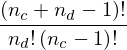

In [32]:
n_c,n_d = sym.symbols('n_c n_d')
q = sym.factorial(n_c+n_d-1)/sym.factorial(n_d)/sym.factorial(n_c-1)
q

Substituting $n_d$ equal to 3 and simplifying gives:

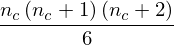

In [33]:
q = sym.simplify(q.subs(n_d,3))
q

and, for the number of components in this solution, there will be the following number of unique terms in the third derivative tensor:

In [34]:
q.subs(n_c,c)

A function is provided to map matrix indices to compact storage 1-D array indices

In [35]:
for i in range(1,c+1):
    for j in range (1,c+1):
        print ("[", end=' ')
        for k in range (1,c+1):
            print ("{0:1d}{1:1d}{2:1d}".format(i,j,k), end=' ')
        print ('] ', end=' ')
    print ('  ->  ', end=' ')
    for j in range (1,c+1):
        print ("[", end=' ')
        for k in range (1,c+1):
            print (model.symmetric_index_from_3d_array(elm=(i,j,k)), end=' ')
        print ('] ', end=' ')
    print ('')

[ 111 112 113 114 115 116 117 ]  [ 121 122 123 124 125 126 127 ]  [ 131 132 133 134 135 136 137 ]  [ 141 142 143 144 145 146 147 ]  [ 151 152 153 154 155 156 157 ]  [ 161 162 163 164 165 166 167 ]  [ 171 172 173 174 175 176 177 ]    ->   [ 0 1 2 3 4 5 6 ]  [ 1 7 8 9 10 11 12 ]  [ 2 8 13 14 15 16 17 ]  [ 3 9 14 18 19 20 21 ]  [ 4 10 15 19 22 23 24 ]  [ 5 11 16 20 23 25 26 ]  [ 6 12 17 21 24 26 27 ]  
[ 211 212 213 214 215 216 217 ]  [ 221 222 223 224 225 226 227 ]  [ 231 232 233 234 235 236 237 ]  [ 241 242 243 244 245 246 247 ]  [ 251 252 253 254 255 256 257 ]  [ 261 262 263 264 265 266 267 ]  [ 271 272 273 274 275 276 277 ]    ->   [ 1 7 8 9 10 11 12 ]  [ 7 28 29 30 31 32 33 ]  [ 8 29 34 35 36 37 38 ]  [ 9 30 35 39 40 41 42 ]  [ 10 31 36 40 43 44 45 ]  [ 11 32 37 41 44 46 47 ]  [ 12 33 38 42 45 47 48 ]  
[ 311 312 313 314 315 316 317 ]  [ 321 322 323 324 325 326 327 ]  [ 331 332 333 334 335 336 337 ]  [ 341 342 343 344 345 346 347 ]  [ 351 352 353 354 355 356 357 ]  [ 361 362 363 364 

In [36]:
def printResult(name, result, units):
    print ("{0:<10.10s}".format(name), end=' ')
    [print ("{0:10.3e}".format(x), end=' ') for x in result]
    print ("{0:<14.14s}".format(units))
def printLabels(n):
    print ("{0:<15.15s}".format(''), end=' ')
    maxIdx = int(len(n)*(len(n)+1)*(len(n)+2)/6)
    [print ("[{0:3d}]{1:<5.5s}".format(idx, ''), end=' ') for idx in range(maxIdx)]
    print ()
printLabels(n)
try:
    printResult('d3Gdn3', Garnet_Solution.cy_Garnet_Garnet_Solution_d3gdn3(t,p,n), 'J/m^3')
    printResult('d4Gdn3dT', Garnet_Solution.cy_Garnet_Garnet_Solution_d4gdn3dt(t,p,n), 'J/K-m^3')
    printResult('d4Gdn3dP', Garnet_Solution.cy_Garnet_Garnet_Solution_d4gdn3dp(t,p,n), 'J/bar-m^3')
    printResult('d5Gdn3dT2', Garnet_Solution.cy_Garnet_Garnet_Solution_d5gdn3dt2(t,p,n), 'J/K^2-m^3')
    printResult('d5Gdn3dTdP', Garnet_Solution.cy_Garnet_Garnet_Solution_d5gdn3dtdp(t,p,n), 'J/K-bar-m^3')
    printResult('d5Gdn3dP2', Garnet_Solution.cy_Garnet_Garnet_Solution_d5gdn3dp2(t,p,n), 'J/bar^2-m^3')
    printResult('d6Gdn3dT3', Garnet_Solution.cy_Garnet_Garnet_Solution_d6gdn3dt3(t,p,n), 'J/K^3-m^3')
    printResult('d6Gdn3dT2dP', Garnet_Solution.cy_Garnet_Garnet_Solution_d6gdn3dt2dp(t,p,n), 'J/K^2-bar-m^3')
    printResult('d6Gdn3dTdP2', Garnet_Solution.cy_Garnet_Garnet_Solution_d6gdn3dtdp2(t,p,n), 'J/K-bar^2-m^3')
    printResult('d6Gdn3dP3', Garnet_Solution.cy_Garnet_Garnet_Solution_d6gdn3dp3(t,p,n), 'J/bar^3-m^3')
except AttributeError:
    pass
try:
    printResult('d3Gdn3', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d3gdn3(t,p,n), 'J/m^3')
    printResult('d4Gdn3dT', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d4gdn3dt(t,p,n), 'J/K-m^3')
    printResult('d4Gdn3dP', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d4gdn3dp(t,p,n), 'J/bar-m^3')
    printResult('d5Gdn3dT2', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d5gdn3dt2(t,p,n), 'J/K^2-m^3')
    printResult('d5Gdn3dTdP', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d5gdn3dtdp(t,p,n), 'J/K-bar-m^3')
    printResult('d5Gdn3dP2', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d5gdn3dp2(t,p,n), 'J/bar^2-m^3')
    printResult('d6Gdn3dT3', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d6gdn3dt3(t,p,n), 'J/K^3-m^3')
    printResult('d6Gdn3dT2dP', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d6gdn3dt2dp(t,p,n), 'J/K^2-bar-m^3')
    printResult('d6Gdn3dTdP2', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d6gdn3dtdp2(t,p,n), 'J/K-bar^2-m^3')
    printResult('d6Gdn3dP3', Garnet_Solution.cy_Garnet_Garnet_Solution_calib_d6gdn3dp3(t,p,n), 'J/bar^3-m^3')
except AttributeError:
    pass

                [  0]      [  1]      [  2]      [  3]      [  4]      [  5]      [  6]      [  7]      [  8]      [  9]      [ 10]      [ 11]      [ 12]      [ 13]      [ 14]      [ 15]      [ 16]      [ 17]      [ 18]      [ 19]      [ 20]      [ 21]      [ 22]      [ 23]      [ 24]      [ 25]      [ 26]      [ 27]      [ 28]      [ 29]      [ 30]      [ 31]      [ 32]      [ 33]      [ 34]      [ 35]      [ 36]      [ 37]      [ 38]      [ 39]      [ 40]      [ 41]      [ 42]      [ 43]      [ 44]      [ 45]      [ 46]      [ 47]      [ 48]      [ 49]      [ 50]      [ 51]      [ 52]      [ 53]      [ 54]      [ 55]      [ 56]      [ 57]      [ 58]      [ 59]      [ 60]      [ 61]      [ 62]      [ 63]      [ 64]      [ 65]      [ 66]      [ 67]      [ 68]      [ 69]      [ 70]      [ 71]      [ 72]      [ 73]      [ 74]      [ 75]      [ 76]      [ 77]      [ 78]      [ 79]      [ 80]      [ 81]      [ 82]      [ 83]      
d3Gdn3     -1.357e+04  1.731e+02  1.731e+02  1.731e+02  1.7

## Test and time the generated functions for Garnet

Time the code

In [37]:
try:
    %timeit(Garnet_Solution.cy_Garnet_Garnet_Solution_g(t, p, n))
except AttributeError:
    pass
try:
    %timeit(Garnet_Solution.cy_Garnet_Garnet_Solution_calib_g(t, p, n))
except AttributeError:
    pass

2.47 µs ± 141 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Time the Rubicon wrapped Objective-C code

In [38]:
from thermoengine import model as stdmodel
modelDB = stdmodel.Database()
GarnetHC = modelDB.get_phase('Grt')

In [39]:
%timeit(GarnetHC.gibbs_energy(t,p,mol=n))

74.4 µs ± 1.46 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Methods available only in the "Calib" versions of generated code
### Execute the parameter value/metadata functions.  
These functions are only defined for the "calibration" model code implementation:

In [40]:
nparam = 0

In [42]:
Garnet_Solution.cy_Garnet_Garnet_Solution_get_param_number()
try:
    nparam = Garnet_Solution.cy_Garnet_Garnet_Solution_get_param_number()
    names = Garnet_Solution.cy_Garnet_Garnet_Solution_get_param_names()
    units = Garnet_Solution.cy_Garnet_Garnet_Solution_get_param_units()
    values = Garnet_Solution.cy_Garnet_Garnet_Solution_get_param_values()
    fmt = "{0:<10.10s} {1:13.6e} {2:13.6e} {3:<10.10s}"
    for i in range(0,nparam):
        print(fmt.format(names[i], values[i], Garnet_Solution.cy_Garnet_Garnet_Solution_get_param_value(i), units[i]))
except AttributeError:
    pass

T_r         2.981500e+02  2.981500e+02 K         
P_r         1.000000e+00  1.000000e+00 bar       
Wh12        0.000000e+00  0.000000e+00 J/m       
Ws12        0.000000e+00  0.000000e+00 J/K-m     
Wv12        0.000000e+00  0.000000e+00 J/bar-m   
dWh12       0.000000e+00  0.000000e+00 J/m       
dWs12       0.000000e+00  0.000000e+00 J/K-m     
dWv12       0.000000e+00  0.000000e+00 J/bar-m   
Wh13        0.000000e+00  0.000000e+00 J/m       
Ws13        0.000000e+00  0.000000e+00 J/K-m     
Wv13        0.000000e+00  0.000000e+00 J/bar-m   
dWh13       0.000000e+00  0.000000e+00 J/m       
dWs13       0.000000e+00  0.000000e+00 J/K-m     
dWv13       0.000000e+00  0.000000e+00 J/bar-m   
Wh14        0.000000e+00  0.000000e+00 J/m       
Ws14        0.000000e+00  0.000000e+00 J/K-m     
Wv14        0.000000e+00  0.000000e+00 J/bar-m   
dWh14       0.000000e+00  0.000000e+00 J/m       
dWs14       0.000000e+00  0.000000e+00 J/K-m     
dWv14       0.000000e+00  0.000000e+00 J/bar-m   


### Functions that allow modification of the array of parameter values

In [43]:
try:
    values[1] = 100.0
    Garnet_Solution.cy_Garnet_Garnet_Solution_set_param_values(values)
    fmt = "{0:<10.10s} {1:13.6e} {2:13.6e} {3:<10.10s}"
    for i in range(0,nparam):
        print(fmt.format(names[i], values[i], Garnet_Solution.cy_Garnet_Garnet_Solution_get_param_value(i), units[i]))
except (AttributeError, NameError):
    pass

T_r         2.981500e+02  2.981500e+02 K         
P_r         1.000000e+02  1.000000e+02 bar       
Wh12        0.000000e+00  0.000000e+00 J/m       
Ws12        0.000000e+00  0.000000e+00 J/K-m     
Wv12        0.000000e+00  0.000000e+00 J/bar-m   
dWh12       0.000000e+00  0.000000e+00 J/m       
dWs12       0.000000e+00  0.000000e+00 J/K-m     
dWv12       0.000000e+00  0.000000e+00 J/bar-m   
Wh13        0.000000e+00  0.000000e+00 J/m       
Ws13        0.000000e+00  0.000000e+00 J/K-m     
Wv13        0.000000e+00  0.000000e+00 J/bar-m   
dWh13       0.000000e+00  0.000000e+00 J/m       
dWs13       0.000000e+00  0.000000e+00 J/K-m     
dWv13       0.000000e+00  0.000000e+00 J/bar-m   
Wh14        0.000000e+00  0.000000e+00 J/m       
Ws14        0.000000e+00  0.000000e+00 J/K-m     
Wv14        0.000000e+00  0.000000e+00 J/bar-m   
dWh14       0.000000e+00  0.000000e+00 J/m       
dWs14       0.000000e+00  0.000000e+00 J/K-m     
dWv14       0.000000e+00  0.000000e+00 J/bar-m   


### Functions that allow modification of a particular parameter value

In [44]:
try:
    Garnet_Solution.cy_Garnet_Garnet_Solution_set_param_value(1, 1.0)
    fmt = "{0:<10.10s} {1:13.6e} {2:13.6e} {3:<10.10s}"
    for i in range(0,nparam):
        print(fmt.format(names[i], values[i], Garnet_Solution.cy_Garnet_Garnet_Solution_get_param_value(i), units[i]))
except AttributeError:
    pass

T_r         2.981500e+02  2.981500e+02 K         
P_r         1.000000e+02  1.000000e+00 bar       
Wh12        0.000000e+00  0.000000e+00 J/m       
Ws12        0.000000e+00  0.000000e+00 J/K-m     
Wv12        0.000000e+00  0.000000e+00 J/bar-m   
dWh12       0.000000e+00  0.000000e+00 J/m       
dWs12       0.000000e+00  0.000000e+00 J/K-m     
dWv12       0.000000e+00  0.000000e+00 J/bar-m   
Wh13        0.000000e+00  0.000000e+00 J/m       
Ws13        0.000000e+00  0.000000e+00 J/K-m     
Wv13        0.000000e+00  0.000000e+00 J/bar-m   
dWh13       0.000000e+00  0.000000e+00 J/m       
dWs13       0.000000e+00  0.000000e+00 J/K-m     
dWv13       0.000000e+00  0.000000e+00 J/bar-m   
Wh14        0.000000e+00  0.000000e+00 J/m       
Ws14        0.000000e+00  0.000000e+00 J/K-m     
Wv14        0.000000e+00  0.000000e+00 J/bar-m   
dWh14       0.000000e+00  0.000000e+00 J/m       
dWs14       0.000000e+00  0.000000e+00 J/K-m     
dWv14       0.000000e+00  0.000000e+00 J/bar-m   


### Functions that evaluate parameter derivatives ...

In [45]:
try:
    fmt = "    {0:<10.10s} {1:13.6e}"
    for i in range(0, np):
        print ('Derivative with respect to parameter: ', names[i], ' of')
        print (fmt.format('G', Garnet_Solution.cy_Garnet_Garnet_Solution_dparam_g(t, p, n, i)))
        print (fmt.format('dGdT', Garnet_Solution.cy_Garnet_Garnet_Solution_dparam_dgdt(t, p, n, i)))
        print (fmt.format('dGdP', Garnet_Solution.cy_Garnet_Garnet_Solution_dparam_dgdp(t, p, n, i)))
        print (fmt.format('d2GdT2', Garnet_Solution.cy_Garnet_Garnet_Solution_dparam_d2gdt2(t, p, n, i)))
        print (fmt.format('d2GdTdP', Garnet_Solution.cy_Garnet_Garnet_Solution_dparam_d2gdtdp(t, p, n, i)))
        print (fmt.format('d2GdP2', Garnet_Solution.cy_Garnet_Garnet_Solution_dparam_d2gdp2(t, p, n, i)))
        print (fmt.format('d3GdT3', Garnet_Solution.cy_Garnet_Garnet_Solution_dparam_d3gdt3(t, p, n, i)))
        print (fmt.format('d3GdT2dP', Garnet_Solution.cy_Garnet_Garnet_Solution_dparam_d3gdt2dp(t, p, n, i)))
        print (fmt.format('d3GdTdP2', Garnet_Solution.cy_Garnet_Garnet_Solution_dparam_d3gdtdp2(t, p, n, i)))
        print (fmt.format('d3GdP3', Garnet_Solution.cy_Garnet_Garnet_Solution_dparam_d3gdp3(t, p, n, i)))
except (AttributeError, TypeError):
    pass

### Parameter derivatives of the chemical potential

In [46]:
def printResult(name, result, units):
    print ("dmu[*]/d {0:<10.10s}".format(name), end=' ')
    [print ("{0:13.6e}".format(x), end=' ') for x in result]
    print ("{0:<12.12s}".format(units))
def printLabels(n):
    print ("         {0:<18.18s}".format(''), end=' ')
    [print ("[{0:3d}]{1:<8.8s}".format(idx, ''), end=' ') for idx in range(len(n))]
    print ()
printLabels(n)
try:
    for i in range(0, nparam):
        result = Garnet_Solution.cy_Garnet_Garnet_Solution_dparam_dgdn(t,p,n, i)
        printResult(names[i], result, 'J/m^2/p-unit')
except AttributeError:
    pass    

                            [  0]         [  1]         [  2]         [  3]         [  4]         [  5]         [  6]         
dmu[*]/d T_r         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 J/m^2/p-unit
dmu[*]/d P_r         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 J/m^2/p-unit
dmu[*]/d Wh12        1.087047e-01  9.850062e-02 -1.374427e-02 -1.374427e-02 -1.374427e-02 -1.374427e-02 -1.374427e-02 J/m^2/p-unit
dmu[*]/d Ws12       -2.174094e+02 -1.970012e+02  2.748855e+01  2.748855e+01  2.748855e+01  2.748855e+01  2.748855e+01 J/m^2/p-unit
dmu[*]/d Wv12        1.087047e-01  9.850062e-02 -1.374427e-02 -1.374427e-02 -1.374427e-02 -1.374427e-02 -1.374427e-02 J/m^2/p-unit
dmu[*]/d dWh12       1.277529e-02 -1.460913e-02  2.804954e-04  2.804954e-04  2.804954e-04  2.804954e-04  2.804954e-04 J/m^2/p-unit
dmu[*]/d dWs12      -2.555058e+01  2.921827e+01 -5.609907e-01 -5.609907e-01 -5.609907e-

dmu[*]/d Wv346      -6.187898e-03 -6.187898e-03  1.713572e-02  1.546974e-02 -6.187898e-03  1.276254e-02 -6.187898e-03 J/m^2/p-unit
dmu[*]/d Wh347      -6.574642e-03 -6.574642e-03  1.820670e-02  1.643660e-02 -6.574642e-03 -6.574642e-03  1.237580e-02 J/m^2/p-unit
dmu[*]/d Ws347       1.314928e+01  1.314928e+01 -3.641340e+01 -3.287321e+01  1.314928e+01  1.314928e+01 -2.475159e+01 J/m^2/p-unit
dmu[*]/d Wv347      -6.574642e-03 -6.574642e-03  1.820670e-02  1.643660e-02 -6.574642e-03 -6.574642e-03  1.237580e-02 J/m^2/p-unit
dmu[*]/d Wh356      -6.629891e-03 -6.629891e-03  1.835970e-02 -6.629891e-03  1.502775e-02  1.367415e-02 -6.629891e-03 J/m^2/p-unit
dmu[*]/d Ws356       1.325978e+01  1.325978e+01 -3.671939e+01  1.325978e+01 -3.005550e+01 -2.734830e+01  1.325978e+01 J/m^2/p-unit
dmu[*]/d Wv356      -6.629891e-03 -6.629891e-03  1.835970e-02 -6.629891e-03  1.502775e-02  1.367415e-02 -6.629891e-03 J/m^2/p-unit
dmu[*]/d Wh357      -7.044259e-03 -7.044259e-03  1.950718e-02 -7.044259e-03  1.5966